This notebook compares scopes that were run with descriptors generated by different featurization methods.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Code.benchmark import Benchmark
from Code.utils import obtain_full_covar_matrix
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys


# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)
wdir = Path(".")


# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14, # Legend titles
    "font.family": "Helvetica"   # Font
    })

In [2]:
datasets = ["high","medium","low"]

In [3]:
# read in the bounds for the normalization
df_bounds = pd.read_csv("./../Amide_data/Datasets/bounds_subs.csv",index_col=0,header=0)

# define a function to extract the relevant bounds in a format suitable for the Benchmark class
def get_bounds(dset):
    bounds = {}
    # get the metrics for the rate objective
    bounds["yield"] = (df_bounds.loc["obj_max",dset],df_bounds.loc["obj_min",dset])
    # get the metrics for the vendi score
    bounds["vendi"] = (df_bounds.loc["vendi_max",dset],df_bounds.loc["vendi_min",dset])

    return bounds

Collect scopes using different featurizations and use the DFT featurization to calculate the final Vendi scores of the selected samples.

In [4]:
# for dset in datasets:
#     for feat in ["mordred","morfeus","rdkit"]:
#         # use the dft featurization (specified by dft_filename) for the Vendi score calculation after the run 
#         # (in the run the Vendi pruning is determined by the respective featurization of the dataset)
#         Benchmark().collect_data(
#             filename_labelled = f"./../Amide_data/Datasets/amide_dset_{feat}_subs_{dset}-yielding.csv",
#             name_results = f"./Results_Data/{dset}-dataset/scope_{feat}",
#             objectives=['yield'],
#             budget = 27,
#             batches = [3],
#             Vendi_pruning_fractions= [13],
#             pruning_metric= "vendi_batch",
#             acquisition_function_mode= "balanced",
#             seeds = 40,
#             init_sampling_method="random",
#             dft_filename=f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv"
#             )

Analyze the results of these scope runs

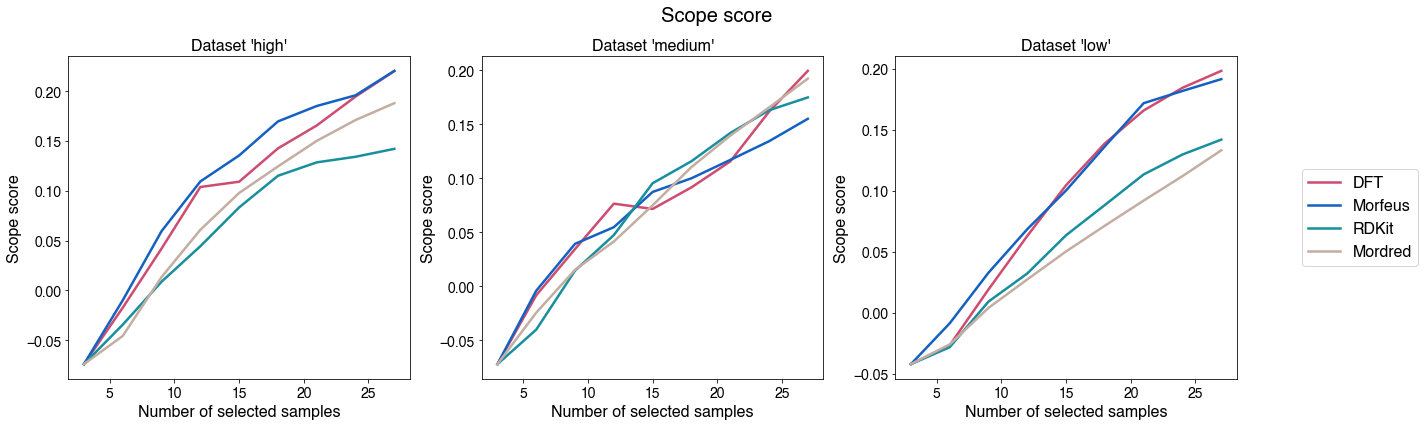

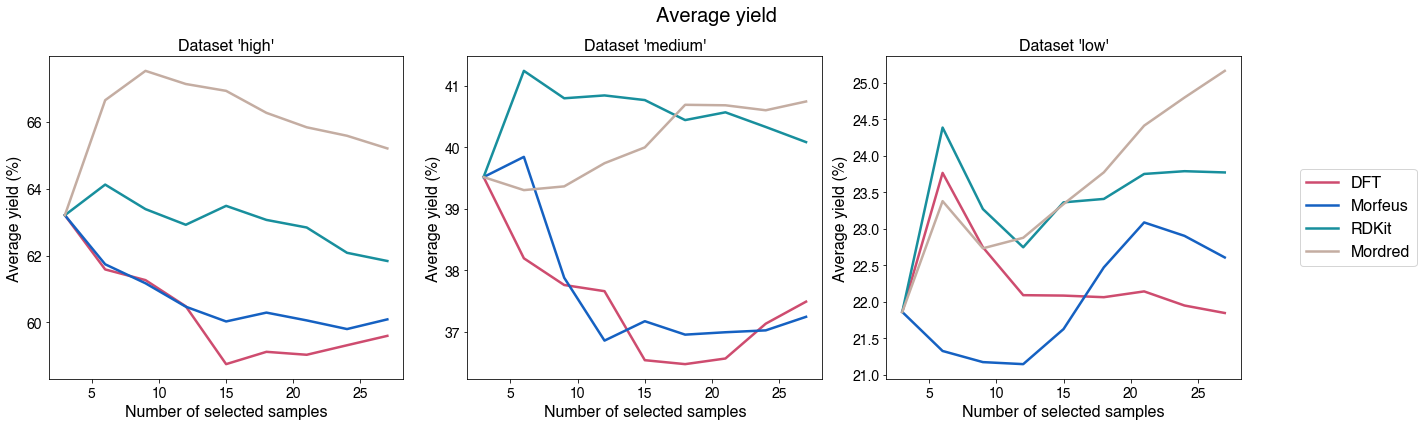

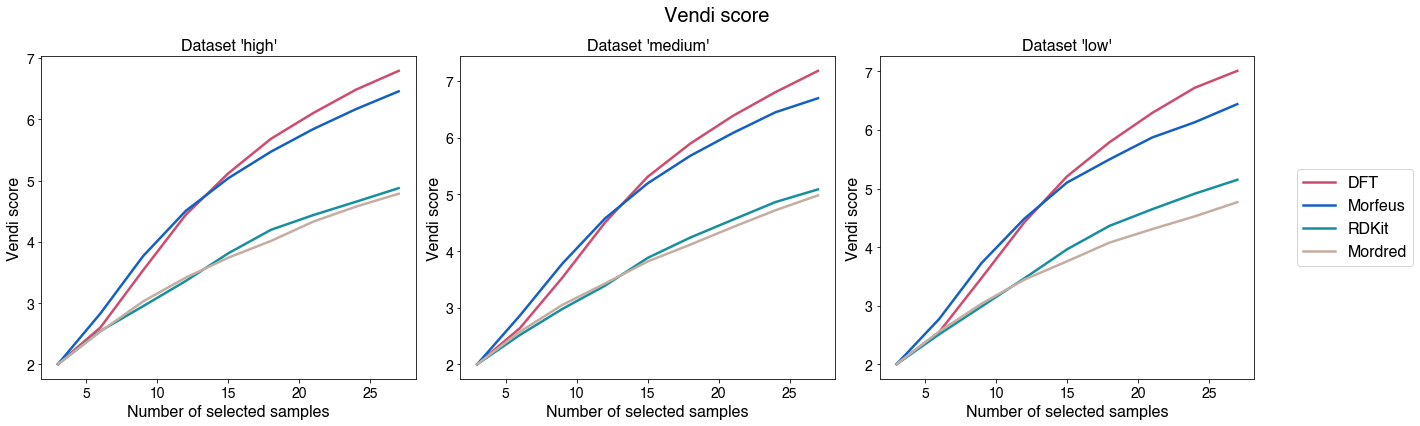

In [5]:
dfs_obj = {}
for type_results in ["Scope","Objective","Vendi"]:
    # Initialize the figure
    fig, axes = plt.subplots(1,4,figsize=(20,6), gridspec_kw={'width_ratios': [1, 1, 1, 0.3]})
    if type_results == "Objective":
        fig.suptitle("Average yield",fontsize=20)
    else:
        fig.suptitle(f"{type_results} score",fontsize=20)
    for i,dset in enumerate(datasets):
        dfs = {}
        for feat in ["DFT","Morfeus","RDKit","Mordred"]:
            if feat == "DFT":
                feat_label = "ei_with-pruning"
            else:
                feat_label = f"scope_{feat.lower()}"
            dfs_progress = Benchmark().progress_plot(budget=27, type_results= type_results,
                                    name_results=f"./Results_Data/{dset}-dataset/{feat_label}",
                                    bounds=get_bounds(dset),show_plot=False)
            if type_results.lower() == "objective":
                dfs_progress["means"] = dfs_progress["means"].applymap(lambda x: x*100)  # scale yields from [0,1] to [0,100]
            dfs[feat] = dfs_progress["means"]
        df_combined = pd.concat(dfs,axis=1)
        df_combined.columns = [multiindex[0] for multiindex in df_combined.columns]
        if type_results == "Objective":
            dfs_obj[dset] = df_combined
        for j,col in enumerate(df_combined.columns):
            style = '-' if j <= 6 else '--' if j <= 13 else ':'
            plotting = df_combined[col][df_combined[col].notna()]
            axes[i].plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)
        axes[i].set_xlabel('Number of selected samples',fontsize=16)
        if type_results == "Objective":
            axes[i].set_ylabel(f"Average yield (%)",fontsize=16)
        else:
            axes[i].set_ylabel(f"{type_results} score",fontsize=16)
        axes[i].set_title(f"Dataset '{dset}'",fontsize=16)
        axes[3].axis('off')
        if i == 0:
            handles_collected, labels_collected = axes[i].get_legend_handles_labels()
        axes[3].legend(handles=handles_collected, labels=labels_collected,
            fontsize=16, loc='center')
    plt.tight_layout()
    plt.show()

Compare the final average yields

In [6]:
# Extract the final average yields
df_obj = pd.DataFrame(np.nan,index=datasets,columns=dfs_obj["high"].columns)
for dset,df in dfs_obj.items():
    df_obj.loc[dset] = df.iloc[-1]  # last row is the final values

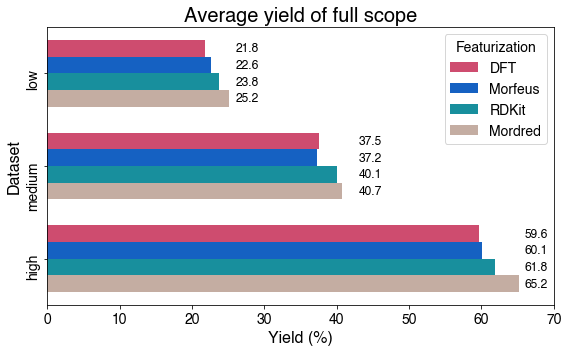

In [7]:
categories = df_obj.index.to_list()
DFT = df_obj["DFT"].to_list()
Morfeus = df_obj["Morfeus"].to_list()
RDKit = df_obj["RDKit"].to_list()
Mordred = df_obj["Mordred"].to_list()

# Parameters
x = np.arange(len(categories))  # positions for groups
bar_height = 0.18               # thickness of each bar
offsets = [1.5, 0.5, -0.5, -1.5]  # to spread bars around center
alpha = 1

# Plot each column side by side for each category
plt.figure(figsize=(8, 5))
plt.barh(x + offsets[0]*bar_height, DFT, height=bar_height, label='DFT', alpha=alpha, color=all_colors[0])
plt.barh(x + offsets[1]*bar_height, Morfeus, height=bar_height, label='Morfeus',alpha=alpha, color=all_colors[1])
plt.barh(x + offsets[2]*bar_height, RDKit, height=bar_height, label='RDKit',alpha=alpha, color=all_colors[2])
plt.barh(x + offsets[3]*bar_height, Mordred, height=bar_height, label='Mordred',alpha=alpha, color=all_colors[3])

# Add labels next to each bar
for i, values in enumerate([DFT, Morfeus, RDKit, Mordred]):
    for j, v in enumerate(values):
        if j == 0:
            plt.text(66, j + offsets[i]*bar_height, f'{v:.1f}', va='center',fontsize=12)
        elif j == 1:
            plt.text(43, j + offsets[i]*bar_height, f'{v:.1f}', va='center',fontsize=12)
        elif j == 2:
            plt.text(26, j + offsets[i]*bar_height, f'{v:.1f}', va='center',fontsize=12)

# Axis labels and title
plt.yticks(x, categories, rotation=90)
plt.xlabel('Yield (%)')
plt.ylabel('Dataset')
plt.xlim(0,70)
plt.title('Average yield of full scope')
plt.legend(title='Featurization')

plt.tight_layout()
plt.show()


The DFT featurization results in the highest scope scores because it achieves the highest Vendi scores, but the average yields are the highest using the lower level Mordred and Rdkit descriptors. This might be because they better model the data or because they model it worse resulting in the Vendi pruning being less efficient and more high performing samples remaining in the search space.

The Vendi scores above have been calculated with the DFT featurization which might bias the analysis towards favoring the DFT featurization which indeed performed best. To check for such a bias, we recalculated the Vendi scores for the selected samples with the other featurizations that we tested.

In [8]:
# for i,dset in enumerate(datasets):
#     dfs = {}
#     for feat in ["DFT","Morfeus","RDKit","Mordred"]:
#         if feat == "DFT":
#             feat_label = "ei_with-pruning"
#         else:
#             feat_label = f"scope_{feat.lower()}"
#         for vendi_feat in ["morfeus","rdkit","mordred"]:
#             Benchmark().change_featurization(name_feat = vendi_feat,
#                                     name_results=f"./Results_Data/{dset}-dataset/{feat_label}",
#                                     filename_labelled=f"./../Amide_data/Datasets/amide_dset_{vendi_feat}_subs_{dset}-yielding.csv",
#                                     directory=".")

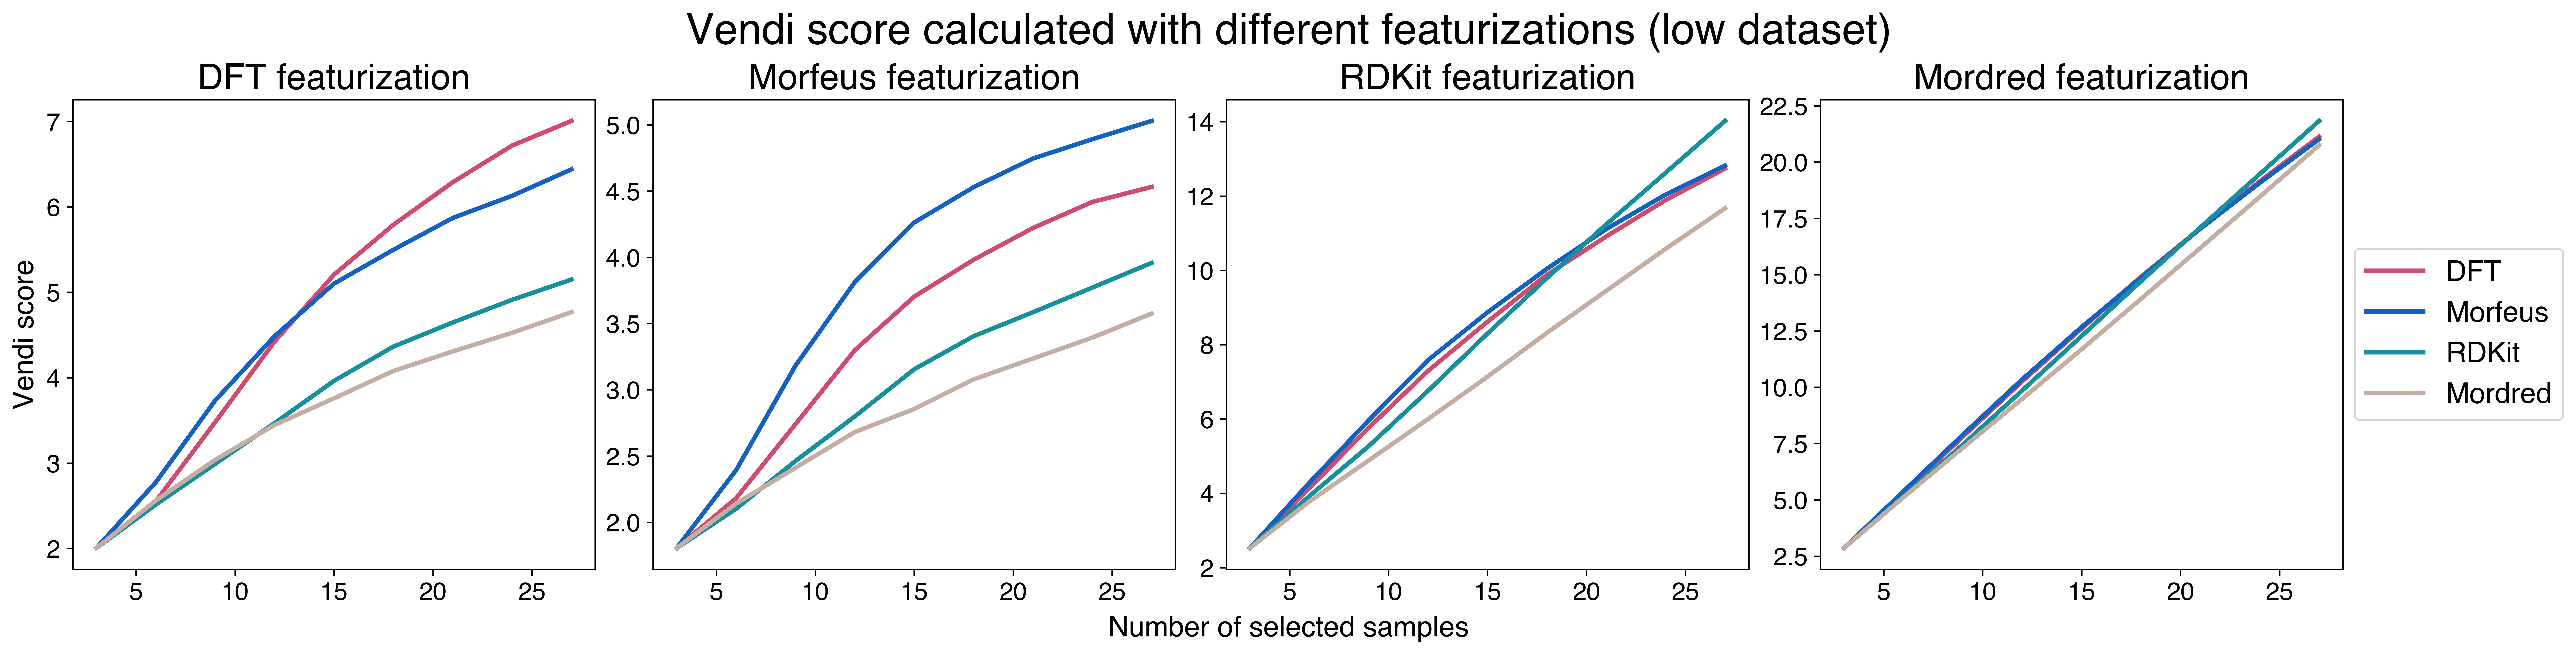

In [9]:
def feat_metric_overview(type_results,dset):
    fig, axes = plt.subplots(1,5, figsize=(20, 5),dpi = 600, gridspec_kw={'width_ratios': [1, 1, 1,1, 0.3]},constrained_layout=True)
    fig.suptitle(f"{type_results} score calculated with different featurizations ({dset} dataset)")

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # To store the legend handles and labels
    handles, labels = [], []

    for i, vendi_feat in enumerate(["DFT", "Morfeus", "RDKit", "Mordred"]):
        if vendi_feat == "DFT":
            vendi_feat_label = ""
        else:
            vendi_feat_label = "_" + vendi_feat.lower() + "_feat"

        dfs = {}
        for feat in ["DFT", "Morfeus", "RDKit", "Mordred"]:
            if feat == "DFT":
                feat_label = "ei_with-pruning"
            else:
                feat_label = f"scope_{feat.lower()}"
            dfs_progress = Benchmark().progress_plot(
                budget=27, 
                type_results=type_results,
                name_results=f"./Results_Data/{dset}-dataset/{feat_label}{vendi_feat_label}",
                bounds=get_bounds(dset), 
                show_plot=False
            )
            dfs[feat] = dfs_progress["means"]
        df_combined = pd.concat(dfs, axis=1)
        df_combined.columns = [multiindex[0] for multiindex in df_combined.columns]
        
        for j,col in enumerate(df_combined.columns):
            style = '-' if j <= 6 else '--' if j <= 13 else ':'
            plotting = df_combined[col][df_combined[col].notna()]
            axes[i].plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)

        # Collect handles and labels for the legend from the first plot
        if i == 0:
            handles, labels = axes[i].get_legend_handles_labels()

        axes[0].set_ylabel(f"{type_results} score")
        axes[i].set_title(f"{vendi_feat} featurization")

    # Add legend to the 6th subplot (empty one)
    axes[4].legend(handles, labels, fontsize=16, loc='center')
    fig.supxlabel('Number of selected samples', fontsize=16)


    # Remove any unused axes (since you only have 5 plots and 6 slots)
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.show()

feat_metric_overview(type_results = "Vendi", dset = "low")

Apart from the Mordred featurization, all featurizations achieve the highest Vendi scores when they are used for the calculation of the Vendi scores. Notably, DFT and Morefus featurization lead to the strongest differentiation of the obtained Vendi scores which might indicate that they better capture differences in the data and therefore describe it better.

Visualization of the selected scopes for the first random seed does not indicate strongly obvious differences in the diversity of the scopes.

Scope selected with DFT featurization:
Yields are on a 0–1 scale


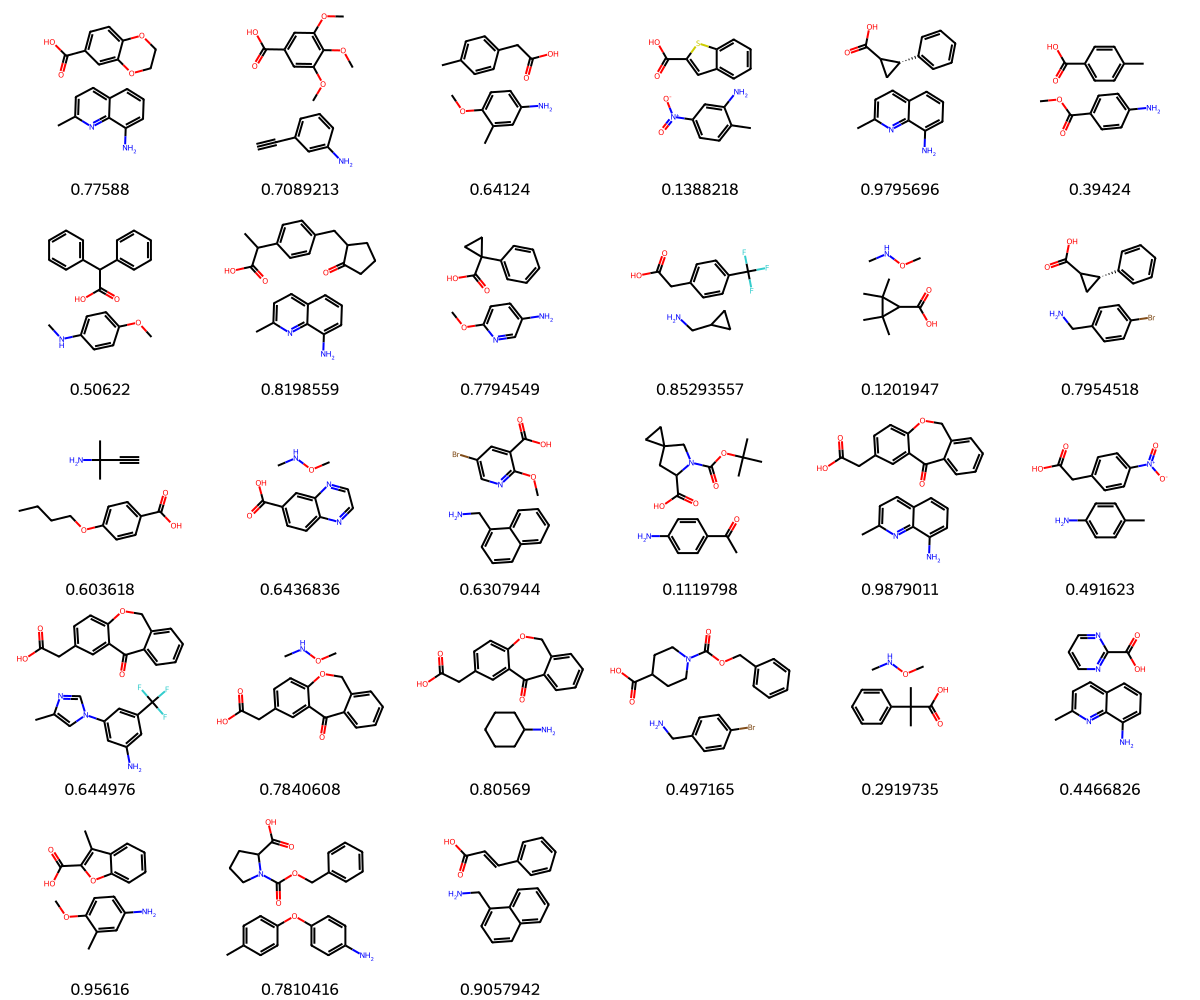

In [10]:
scopes = {}
print("Scope selected with DFT featurization:")
print("Yields are on a 0–1 scale")
scopes["dft"] = Benchmark().show_scope(filename_data=f"27balanced_b3_V13_s0.csv",
                        name_results=f"./Results_Data/high-dataset/ei_with-pruning/raw_data",
                        by_round=False,rounds_to_display=9,give_data=True)

Scope selected with Mordred featurization:
Yields are on a 0–1 scale


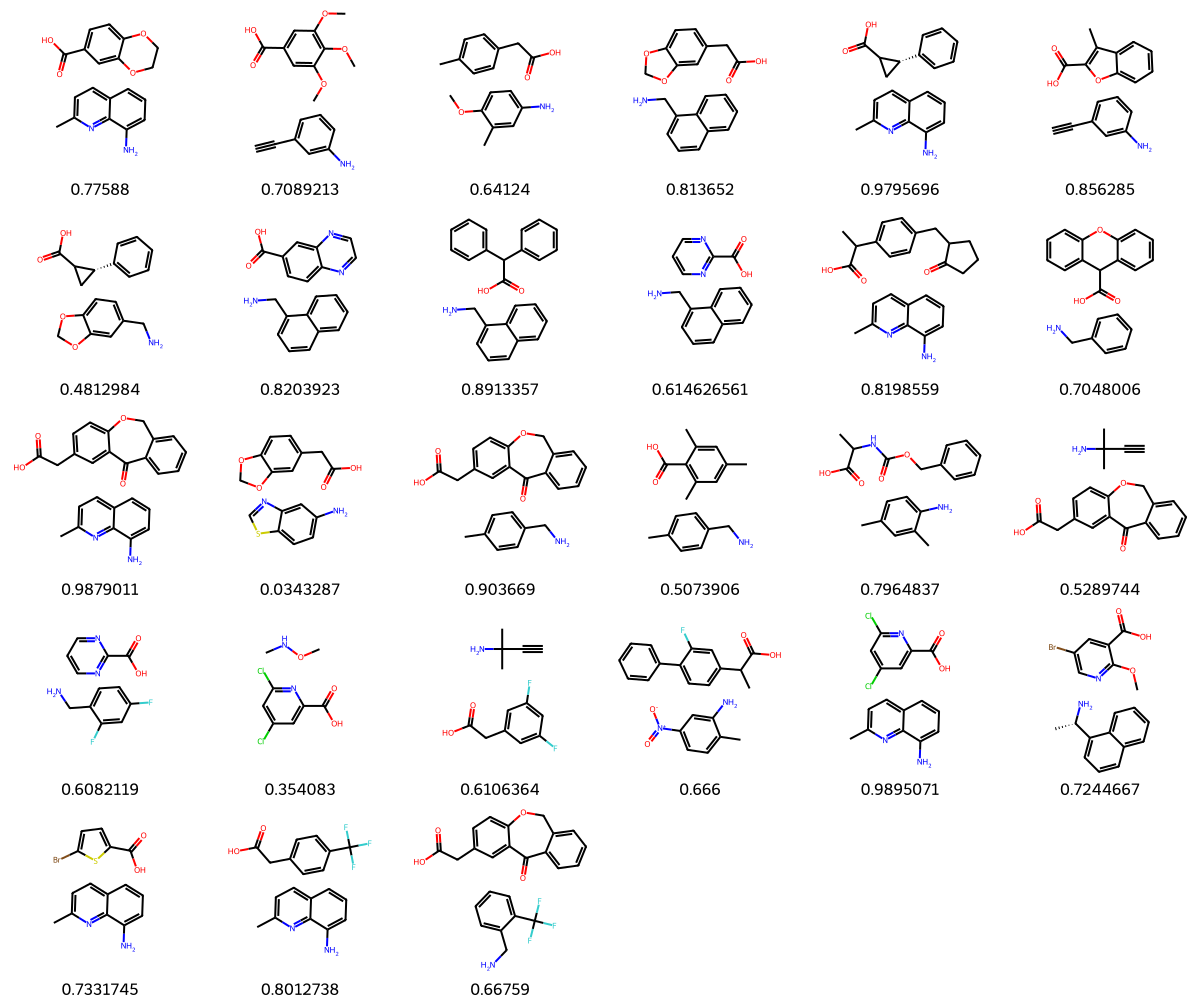

In [11]:
print("Scope selected with Mordred featurization:")
print("Yields are on a 0–1 scale")

scopes["mordred"] = Benchmark().show_scope(filename_data=f"27balanced_b3_V13_s0.csv",
                        name_results=f"./Results_Data/high-dataset/scope_mordred_mordred_feat/raw_data",
                        by_round=False,rounds_to_display=9,give_data=True)

Yields are on a 0–1 scale
Scope selected with RDKit featurization:


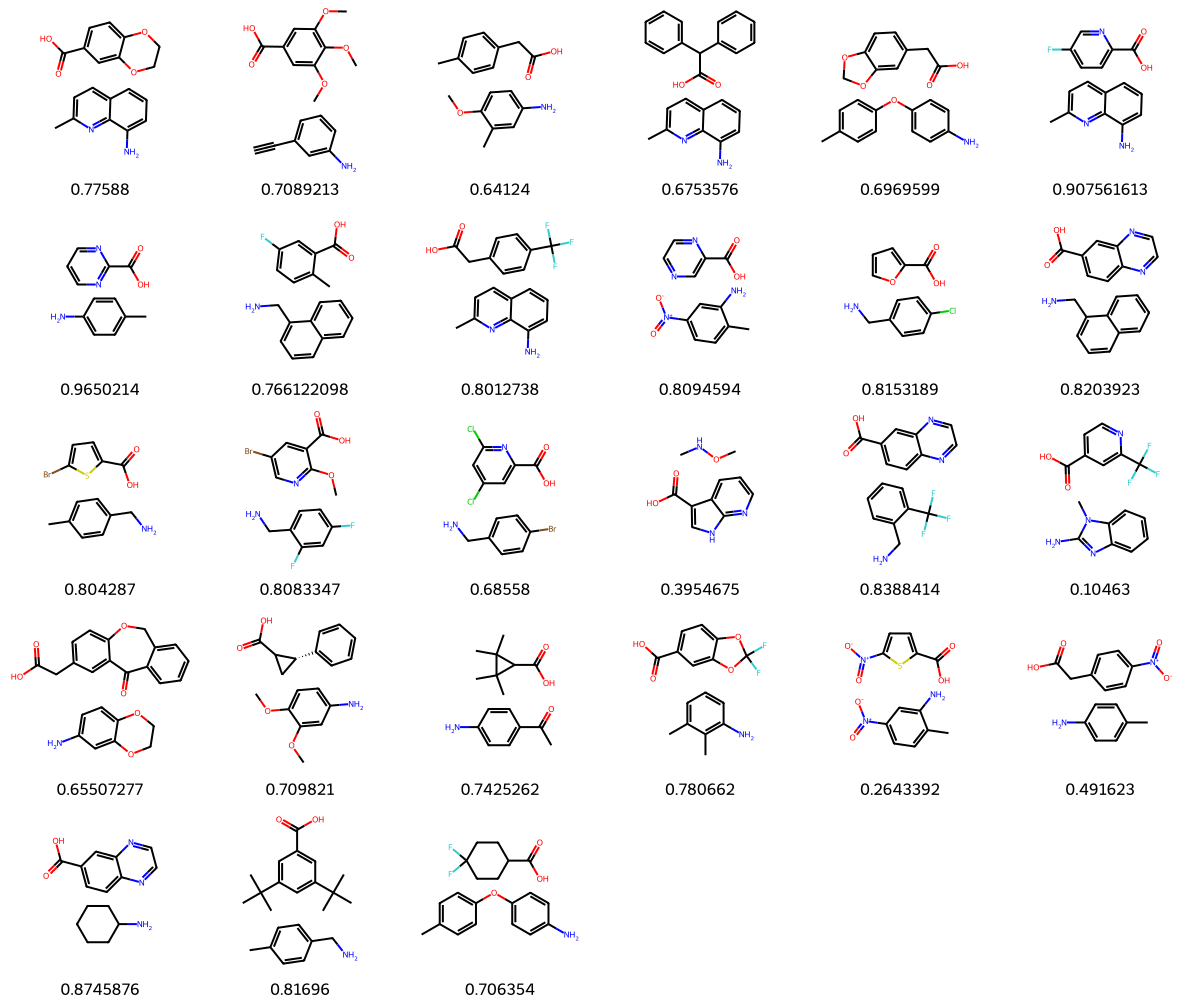

In [12]:
print("Yields are on a 0–1 scale")
print("Scope selected with RDKit featurization:")
scopes["rdkit"] = Benchmark().show_scope(filename_data=f"27balanced_b3_V13_s0.csv",
                        name_results=f"./Results_Data/high-dataset/scope_rdkit_rdkit_feat/raw_data",
                        by_round=False,rounds_to_display=9,give_data=True)

Yields are on a 0–1 scale
Scope selected with Morfeus featurization:


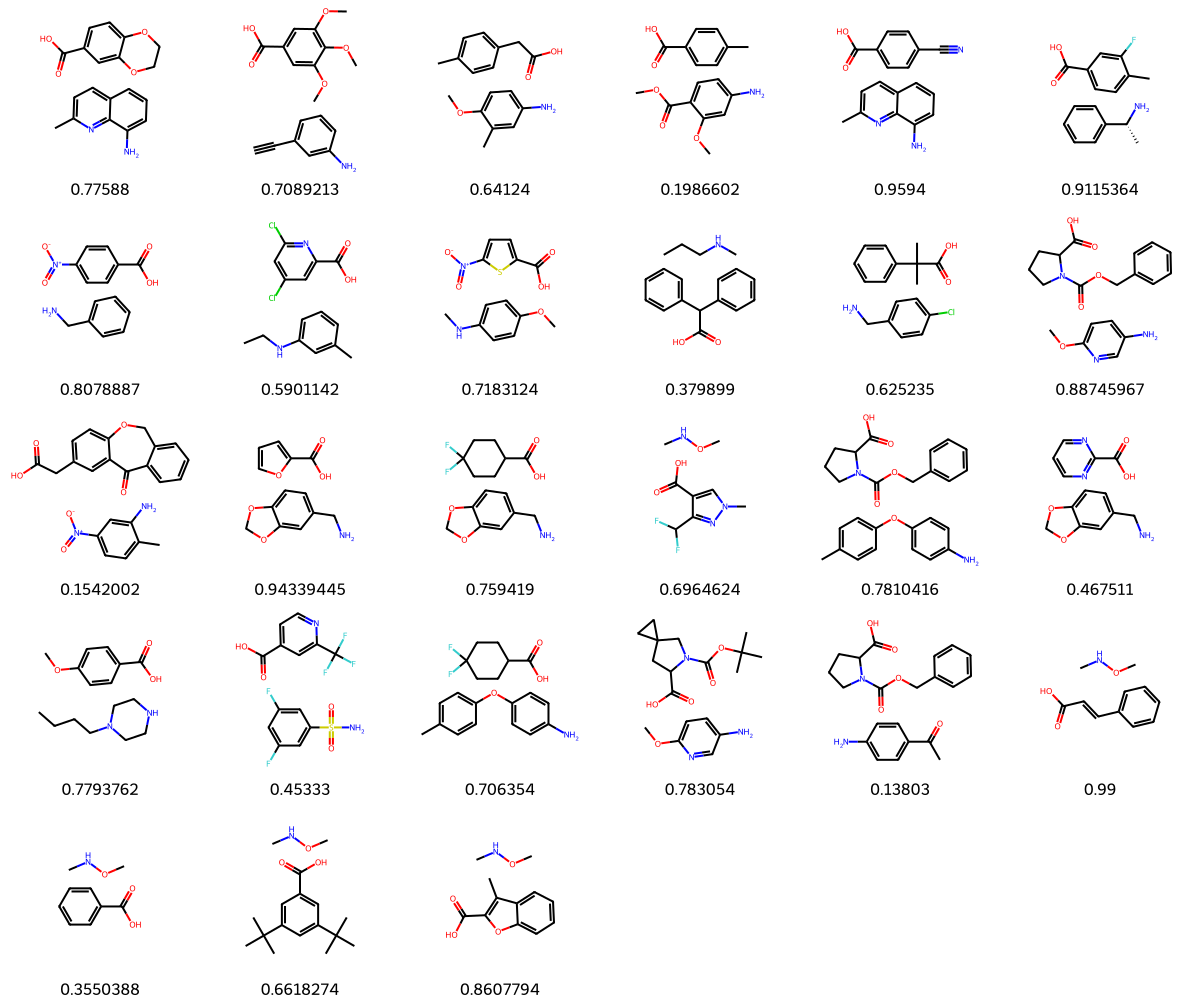

In [13]:
print("Yields are on a 0–1 scale")
print("Scope selected with Morfeus featurization:")
scopes["morfeus"] = Benchmark().show_scope(filename_data=f"27balanced_b3_V13_s0.csv",
                        name_results=f"./Results_Data/high-dataset/scope_morfeus_morfeus_feat/raw_data",
                        by_round=False,rounds_to_display=9,give_data=True)

We can also compare how many different acids and amines were selected by the different featurization methods.

In [14]:
dict_subs_summ = {}
for seed in range(40):
    scopes = {}
    for feat in ["dft","mordred","morfeus","rdkit"]:
        feat_label = f"scope_{feat}_{feat}_feat"
        if feat == "dft":
            feat_label = "ei_with-pruning"
        scopes[feat] = Benchmark().show_scope(filename_data=f"27balanced_b3_V13_s{seed}.csv",
                                name_results=f"./Results_Data/high-dataset/{feat_label}/raw_data",
                                give_data=True,suppress_figure=True)
    subs_summ = pd.DataFrame(np.nan,index=["acid","amine"],columns=scopes.keys())
    for key in scopes.keys():
        subs_summ.loc["amine",key] = len(set([entry.split(".")[0] for entry in scopes[key].keys()]))
        subs_summ.loc["acid",key] = len(set([entry.split(".")[1] for entry in scopes[key].keys()]))
    dict_subs_summ[seed] = subs_summ

In [15]:
print("Unique average substrates per scope:")
av_subs_summ = pd.concat(dict_subs_summ.values()).groupby(level=0).mean()
av_subs_summ.loc["Sum"] = av_subs_summ.sum()
av_subs_summ


Unique average substrates per scope:


dft  mordred  morfeus  rdkit
acid   21.575   20.625    20.60  19.80
amine  17.700   16.725    17.95  19.35
Sum    39.275   37.350    38.55  39.15

The analysis of unique substrates is led by DFT and Morfeus, but again no strong differences are notable.

We also calculated other, more orthogonal similarity matrices as the basis for the Vendi score calculation:
* geometric mean of the different covariance matrices
* Tanimoto similarity of the RDKit fingerprints
* Tanimoto similarity of the MOrgan fingerprints

Average covariance

In [16]:
# calculate an average similarity matrix by taking the geometric mean of the covariance matrices for all the different featurization methods
dict_cov_mat = {}
for feat in ["DFT","Morfeus","RDKit","Mordred"]:
        # NOTE: obtain_full_covar_matrix automatically sorts the dataframes by index so that the indexing between the cov mat will be consistent
        dict_cov_mat[feat] = obtain_full_covar_matrix(objectives=["yield"],directory=".",
                                        filename=f"./../Amide_data/Datasets/amide_dset_{feat.lower()}_subs_high-yielding.csv")
# calculate geometic mean
stacked = np.stack([mat.values for mat in dict_cov_mat.values()])
# replace zero values in the covariance matrices with a small jitter 
stacked = np.where(stacked == 0, 1e-16, stacked)
geom_mean = np.exp(np.mean(np.log(stacked),axis=0))
# convert to df
av_cov_mat = pd.DataFrame(geom_mean)

In [17]:
# # recalculate the Vendi scores using the averaged covariance matrix
# for i,dset in enumerate(datasets):
#     dfs = {}
#     for feat in ["DFT","Morfeus","RDKit","Mordred"]:
#         if feat == "DFT":
#             feat_label = "ei_with-pruning"
#         else:
#             feat_label = f"scope_{feat.lower()}"
#         # NOTE: The labelled data with the DFT features is required to assign the samples but the featurization is NOT used.
#         Benchmark().change_featurization(name_feat = "av-cov",
#                                     name_results=f"./Results_Data/{dset}-dataset/{feat_label}",
#                                     filename_labelled=f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",
#                                     cov_mat= av_cov_mat,
#                                     directory=".")

In [18]:
# as dft and morfeus featurization are conceptionally similar and dft-rdkit also is similar to dft and rdkit,
# we also calculate an average covariance that only contains the more orthogonal featurizations dft, mordred, rdkit

dict_cov_mat_pruned = {k: dict_cov_mat[k] for k in ["DFT","RDKit","Mordred"]}
# calculate geometic mean
stacked = np.stack([mat.values for mat in dict_cov_mat_pruned.values()])
# replace zero values in the covariance matrices with a small jitter 
stacked = np.where(stacked == 0, 1e-16, stacked)
geom_mean = np.exp(np.mean(np.log(stacked),axis=0))
# convert to df
av_cov_mat_pruned = pd.DataFrame(geom_mean)

In [19]:
# # recalculate the Vendi scores using the averaged covariance matrix for only DFT, RDKit, and Mordred
# for i,dset in enumerate(datasets):
#     dfs = {}
#     for feat in ["DFT","Morfeus","RDKit","Mordred"]:
#         if feat == "DFT":
#             feat_label = "ei_with-pruning"
#         else:
#             feat_label = f"scope_{feat.lower()}"
#         # NOTE: The labelled data with the DFT features is required to assign the samples but the featurization is NOT used.
#         Benchmark().change_featurization(name_feat = "av-cov-pruned",
#                                     name_results=f"./Results_Data/{dset}-dataset/{feat_label}",
#                                     filename_labelled=f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",
#                                     cov_mat= av_cov_mat_pruned,
#                                     directory=".")

Get the pairwise Tanimoto similarity as another covariance matrix (using the RDKit fingerprint)

In [20]:
# get the molecules and convert to Mol objects
df_labelled = pd.read_csv(f"./../Amide_data/Datasets/amide_dset_dft_subs_high-yielding.csv", index_col=0,header=0)
df_labelled.sort_index(inplace=True)
mols = [Chem.MolFromSmiles(smiles) for smiles in df_labelled.index]
# instantiate fingerprint generator
rdk_fpg = rdFingerprintGenerator.GetRDKitFPGenerator()
# create the fingerprints
rdk_fps = [rdk_fpg.GetFingerprint(mol) for mol in mols]
# calculate the Tanimoto similarities
n = len(rdk_fps)
tanimoto_matrix = np.zeros((n, n))
for i in range(n):
    sims = DataStructs.BulkTanimotoSimilarity(rdk_fps[i], rdk_fps)
    tanimoto_matrix[i, :] = sims  # Fill row i

# convert to df
tanimoto_df = pd.DataFrame(tanimoto_matrix)


In [21]:
# # recalculate the Vendi scores using the tanimoto similarity of the rdkit fingerprints
# for i,dset in enumerate(datasets):
#     dfs = {}
#     for feat in ["DFT","Morfeus","RDKit","Mordred"]:
#         if feat == "DFT":
#             feat_label = "ei_with-pruning"
#         else:
#             feat_label = f"scope_{feat.lower()}"
#         # NOTE: The labelled data with the DFT features is required to assign the samples but the featurization is NOT used.
#         Benchmark().change_featurization(name_feat = "tanimoto",
#                                     name_results=f"./Results_Data/{dset}-dataset/{feat_label}",
#                                     filename_labelled=f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",
#                                     cov_mat= tanimoto_df,
#                                     directory=".")

Get the Tanimoto similarity using the Morgan fingerprint (for both radius 2 and 3)

In [22]:
# get the molecules and convert to Mol objects
df_labelled.sort_index(inplace=True)
mols = [Chem.MolFromSmiles(smiles) for smiles in df_labelled.index]
# instantiate fingerprint generator
mfp_fpg = rdFingerprintGenerator.GetMorganGenerator(radius = 2)
# create the fingerprints
mfp_fps = [mfp_fpg.GetFingerprint(mol) for mol in mols]
# calculate the Tanimoto similarities
n = len(mfp_fps)
tanimoto_matrix = np.zeros((n, n))
for i in range(n):
    sims = DataStructs.BulkTanimotoSimilarity(rdk_fps[i], mfp_fps)
    tanimoto_matrix[i, :] = sims  # Fill row i

# convert to df
tanimoto_df = pd.DataFrame(tanimoto_matrix)


In [23]:
# # recalculate the Vendi scores using the tanimoto similarity of the morgan fingerprints with radius 2
# for i,dset in enumerate(datasets):
#     dfs = {}
#     for feat in ["DFT","Morfeus","RDKit","Mordred"]:
#         if feat == "DFT":
#             feat_label = "ei_with-pruning"
#         else:
#             feat_label = f"scope_{feat.lower()}"
#         # NOTE: The labelled data with the DFT features is required to assign the samples but the featurization is NOT used.
#         Benchmark().change_featurization(name_feat = "tanimoto-morgan2",
#                                     name_results=f"./Results_Data/{dset}-dataset/{feat_label}",
#                                     filename_labelled=f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",
#                                     cov_mat= tanimoto_df,
#                                     directory=".")

In [24]:
# get the molecules and convert to Mol objects
df_labelled.sort_index(inplace=True)
mols = [Chem.MolFromSmiles(smiles) for smiles in df_labelled.index]
# instantiate fingerprint generator
mfp_fpg = rdFingerprintGenerator.GetMorganGenerator(radius = 3)
# create the fingerprints
mfp_fps = [mfp_fpg.GetFingerprint(mol) for mol in mols]
# calculate the Tanimoto similarities
n = len(mfp_fps)
tanimoto_matrix = np.zeros((n, n))
for i in range(n):
    sims = DataStructs.BulkTanimotoSimilarity(rdk_fps[i], mfp_fps)
    tanimoto_matrix[i, :] = sims  # Fill row i

# convert to df
tanimoto_df = pd.DataFrame(tanimoto_matrix)


In [25]:
# # recalculate the Vendi scores using the tanimoto similarity of the morgan fingerprints with radius 3
# for i,dset in enumerate(datasets):
#     dfs = {}
#     for feat in ["DFT","Morfeus","RDKit","Mordred"]:
#         if feat == "DFT":
#             feat_label = "ei_with-pruning"
#         else:
#             feat_label = f"scope_{feat.lower()}"
#         # NOTE: The labelled data with the DFT features is required to assign the samples but the featurization is NOT used.
#         Benchmark().change_featurization(name_feat = "tanimoto-morgan3",
#                                     name_results=f"./Results_Data/{dset}-dataset/{feat_label}",
#                                     filename_labelled=f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",
#                                     cov_mat= tanimoto_df,
#                                     directory=".")

Visualize the Vendi scores using the averaged similarity and the tanimoto similarity

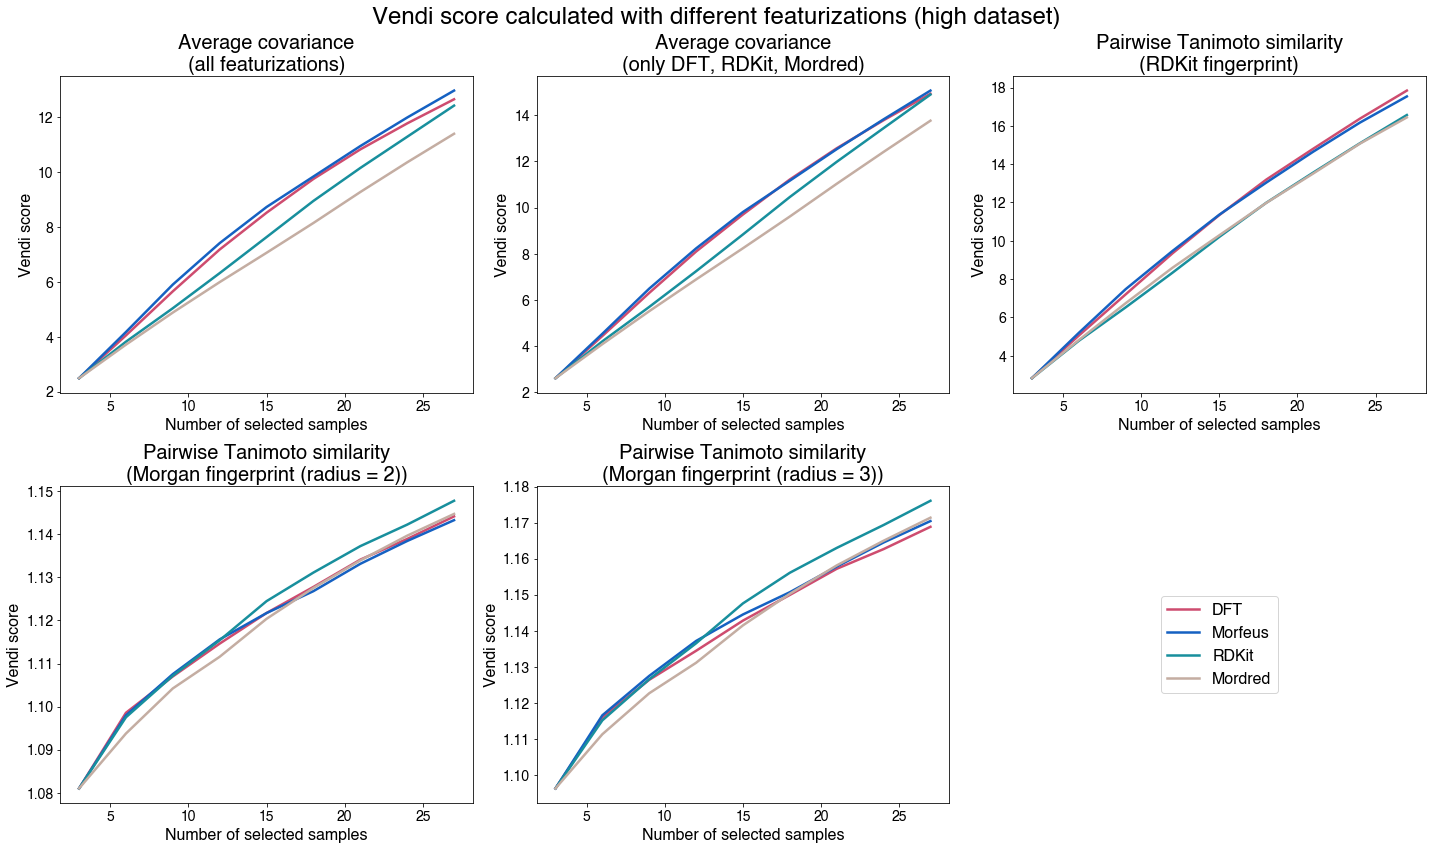

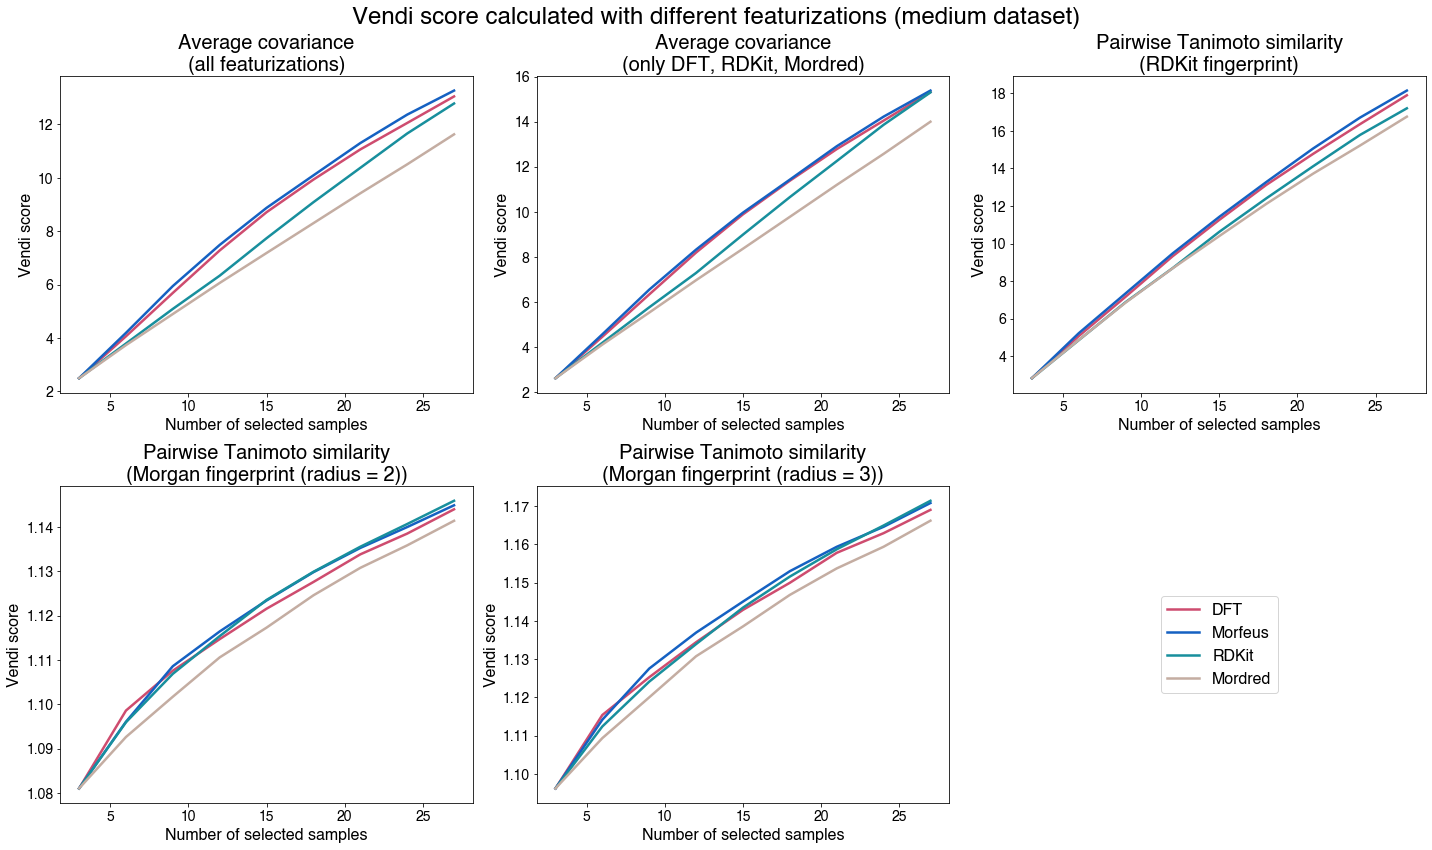

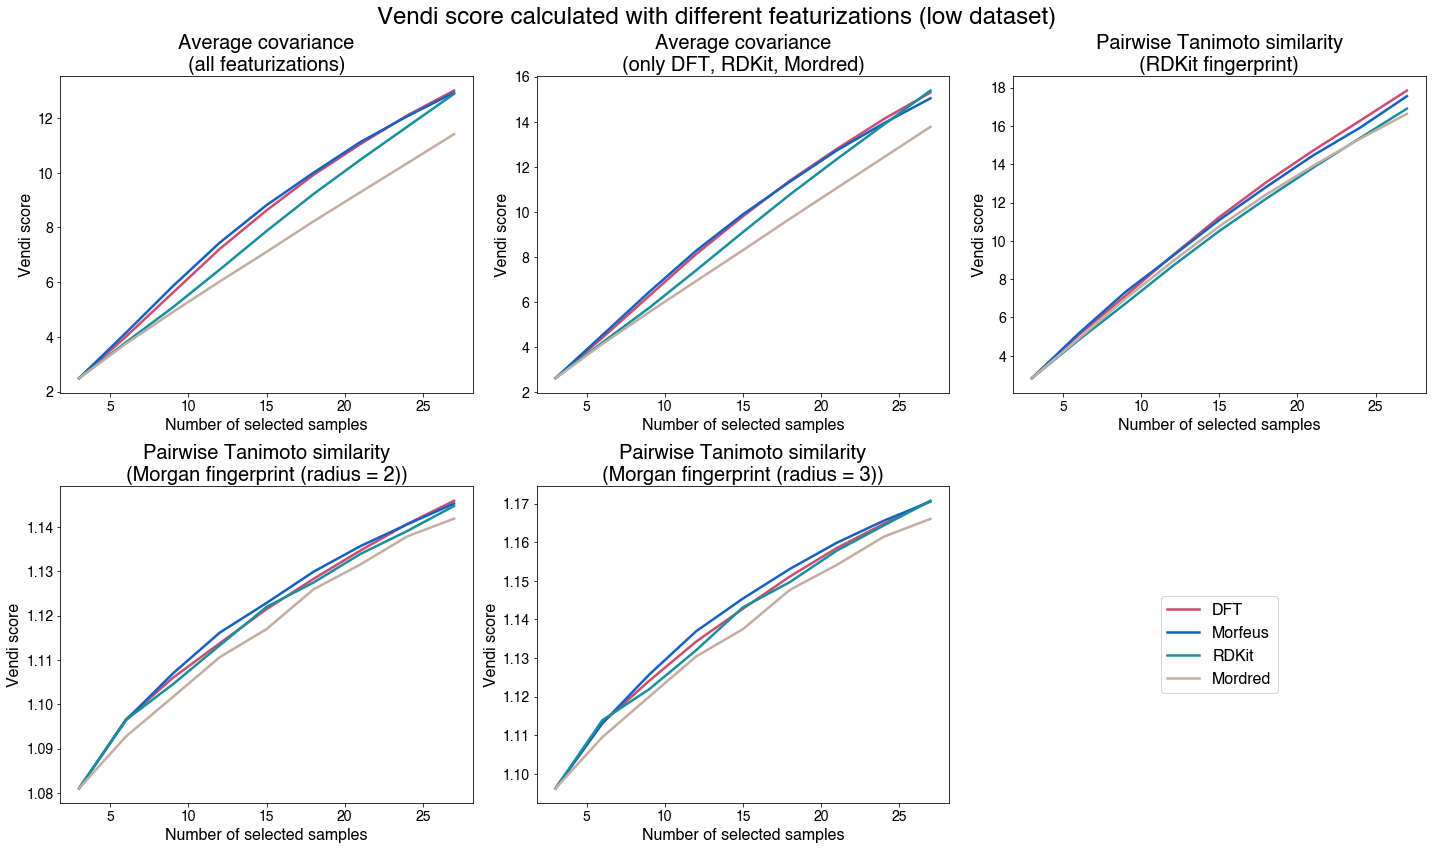

In [26]:
type_results = "Vendi"

analysis_feat = {"Average covariance\n(only DFT, RDKit, Mordred)": "Average covariance",
                 "Pairwise Tanimoto similarity\n(RDKit fingerprint)": "Tanimoto_Rdkit-FP",
                 "Pairwise Tanimoto similarity\n(Morgan fingerprint (radius = 2))": "Tanimoto_Morgan2-FP"
                 }
feat_list = ["DFT", "Morfeus", "RDKit", "Mordred"]

final_scores = {}


for dset in datasets:

    scores_dset = pd.DataFrame(np.nan,index=feat_list,columns=analysis_feat.values())

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    fig.suptitle(f"{type_results} score calculated with different featurizations ({dset} dataset)", fontsize=24)

    # To store the legend handles and labels
    handles, labels = [], []

    for i, vendi_feat in enumerate(["Average covariance\n(all featurizations)",
                                    "Average covariance\n(only DFT, RDKit, Mordred)",
                                    "Pairwise Tanimoto similarity\n(RDKit fingerprint)",
                                    "Pairwise Tanimoto similarity\n(Morgan fingerprint (radius = 2))",
                                    "Pairwise Tanimoto similarity\n(Morgan fingerprint (radius = 3))"]):
        if vendi_feat == "Average covariance\n(all featurizations)":
            vendi_feat_label = "_av-cov_feat"
        elif vendi_feat == "Average covariance\n(only DFT, RDKit, Mordred)":
            vendi_feat_label = "_av-cov-pruned_feat"
        elif vendi_feat == "Pairwise Tanimoto similarity\n(RDKit fingerprint)":
            vendi_feat_label = "_tanimoto_feat"
        elif vendi_feat == "Pairwise Tanimoto similarity\n(Morgan fingerprint (radius = 2))":
            vendi_feat_label = "_tanimoto-morgan2_feat"
        elif vendi_feat == "Pairwise Tanimoto similarity\n(Morgan fingerprint (radius = 3))":
            vendi_feat_label = "_tanimoto-morgan3_feat"

        dfs = {}
        for feat in feat_list:
            if feat == "DFT":
                feat_label = "ei_with-pruning"
            else:
                feat_label = f"scope_{feat.lower()}"
            dfs_progress = Benchmark().progress_plot(
                budget=27, 
                type_results=type_results,
                name_results=f"./Results_Data/{dset}-dataset/{feat_label}{vendi_feat_label}",
                bounds=get_bounds(dset), 
                show_plot=False
            )
            dfs[feat] = dfs_progress["means"]

            if vendi_feat in analysis_feat:
                scores_dset.loc[feat,analysis_feat[vendi_feat]] = dfs[feat].loc[27,"b3_V13"]

        final_scores[dset] = scores_dset

        df_combined = pd.concat(dfs, axis=1)
        df_combined.columns = [multiindex[0] for multiindex in df_combined.columns]
        
        for j,col in enumerate(df_combined.columns):
            style = '-' if j <= 6 else '--' if j <= 13 else ':'
            plotting = df_combined[col][df_combined[col].notna()]
            axes[i].plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)

        # Collect handles and labels for the legend from the first plot
        if i == 0:
            handles, labels = axes[i].get_legend_handles_labels()

        axes[i].set_xlabel('Number of selected samples', fontsize=16)
        axes[i].set_ylabel(f"{type_results} score", fontsize=16)
        axes[i].set_title(f"{vendi_feat}", fontsize=20)

    # Add legend to the 6th subplot (empty one)
    axes[5].legend(handles, labels, fontsize=16, loc='center')

    # Remove any unused axes (since you only have 5 plots and 6 slots)
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [27]:
norm_scores = {}

for dset in datasets:
    scaler = MinMaxScaler()
    norm_scores[dset] = pd.DataFrame(scaler.fit_transform(final_scores[dset].to_numpy()),index=final_scores[dset].index,columns=final_scores[dset].columns)

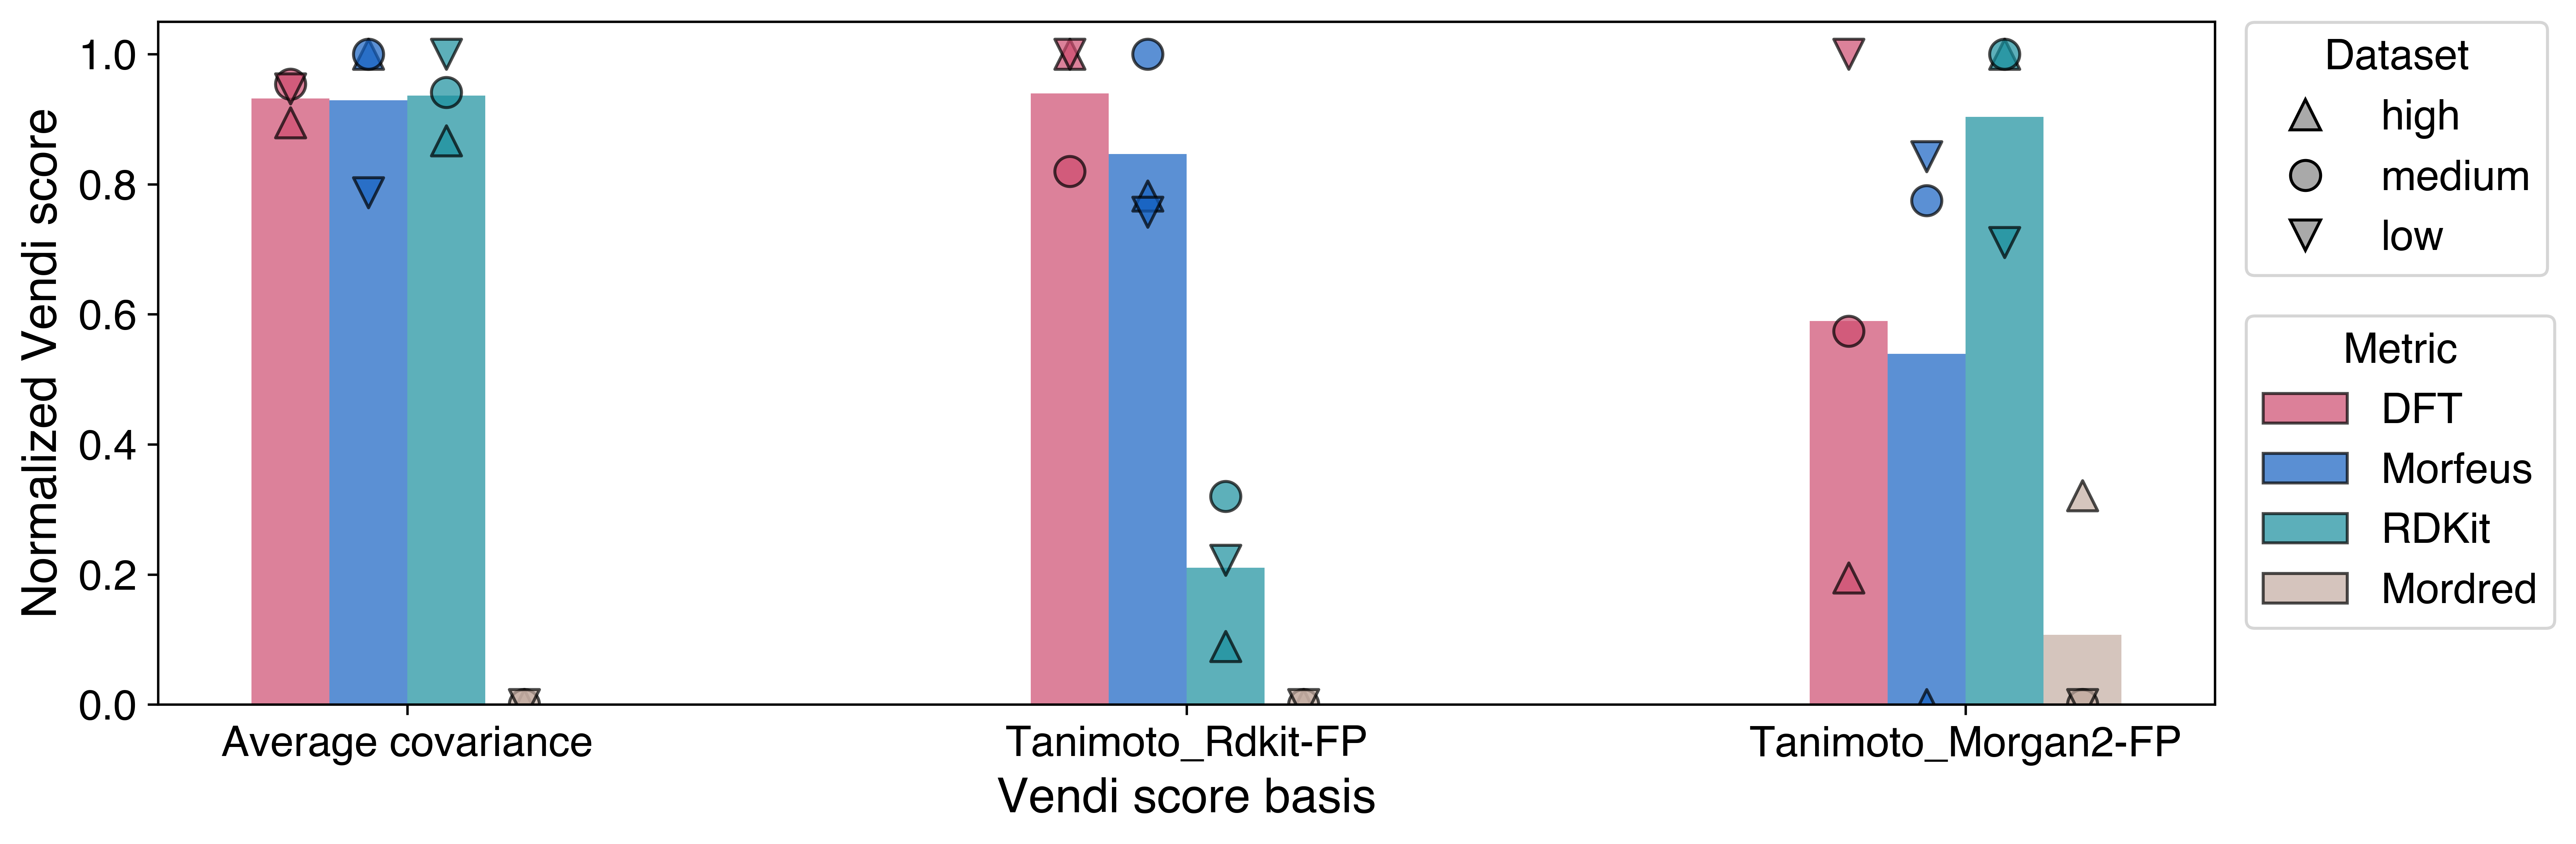

In [28]:
# make a summary plot

records = []
for dataset_name, df in norm_scores.items():
    for idx in df.index:
        for metric in df.columns:
            records.append({
                'Dataset': dataset_name,
                'Metric': metric,
                'Index': idx,
                'Score': df.loc[idx, metric]
            })

long_df = pd.DataFrame(records)
offsets = {'DFT': -0.15, 'Morfeus': -0.05, 'RDKit': 0.05, "Mordred": 0.15}
long_df['XOffset'] = long_df['Index'].map(offsets)

# Positions for each metric
metrics = list(norm_scores["high"].columns)
x_pos_map = {metric: i for i, metric in enumerate(metrics)}
long_df['XBase'] = long_df['Metric'].map(x_pos_map)
long_df['X'] = long_df['XBase'] + long_df['XOffset']

# Plotting
plt.figure(figsize=(12, 4),dpi=600)
markers = {'high': '^', 'medium': 'o', 'low': 'v'}
colors = {feat_list[i]: all_colors[i] for i in range(4)}

# Plot each combination of metric and dataset
for dataset in norm_scores.keys():
    for idx in norm_scores["high"].index:
        subset = long_df[(long_df['Dataset'] == dataset) & (long_df['Index'] == idx)]
        plt.scatter(
            subset['X'], 
            subset['Score'], 
            marker=markers[dataset],
            color=colors[idx],
            s=100,
            edgecolor='k',
            linewidths=1,
            alpha=0.7
        )

# Legend for Dataset (marker)
dataset_legend = [
    Line2D([0], [0], marker=markers[name], color='w', label=name,
           markerfacecolor=all_colors[6], markeredgecolor='k', markersize=10)
    for name in markers
]

# Legend for featurization (color)
index_legend = [
    Patch(facecolor=colors[name], edgecolor='k', label=name, alpha = 0.7)
    for name in colors
]

# Add the legends
legend1 = plt.legend(handles=dataset_legend, title='Dataset', loc='upper left', bbox_to_anchor=(1.005, 1.03))
legend2 = plt.legend(handles=index_legend, title='Metric', loc='upper left', bbox_to_anchor=(1.005, 0.6))
plt.gca().add_artist(legend1)  # Add the first legend back after second one replaces it

plt.xticks(ticks=range(len(metrics)), labels=metrics)
plt.ylabel('Normalized Vendi score')


# calculate the averages
avg_scores = (
    long_df
    .groupby(['Metric', 'Index'], as_index=False)['Score']
    .mean()
)

# map the averages to the plot positions
avg_scores['XBase'] = avg_scores['Metric'].map(x_pos_map)
avg_scores['XOffset'] = avg_scores['Index'].map(offsets)
avg_scores['X'] = avg_scores['XBase'] + avg_scores['XOffset']

# plot the averages as a barplot
bar_width = 0.10
for idx, color in colors.items():
    subset = avg_scores[avg_scores['Index'] == idx]
    plt.bar(
        subset['X'], 
        subset['Score'], 
        width=bar_width, 
        color=color, 
        alpha=0.7, 
        label=f'{idx} avg', zorder = 0
    )

plt.xlabel("Vendi score basis")

plt.tight_layout()
plt.show()


The average covariance in this case is the one that only incorporates the DFT, Mordred, and RDKit featurization covariance matrices.

In [29]:
av_norm_scores = pd.DataFrame(np.mean(np.stack([df.values for df in norm_scores.values()]),axis=0),index=norm_scores["high"].index,columns=norm_scores["high"].columns)
av_norm_scores["Average"] = av_norm_scores.mean(axis=1)
av_norm_scores

Average covariance  Tanimoto_Rdkit-FP  Tanimoto_Morgan2-FP   Average
DFT                0.931815           0.939909             0.589609  0.820444
Morfeus            0.929085           0.846353             0.539288  0.771575
RDKit              0.936233           0.210584             0.903562  0.683460
Mordred            0.000000           0.000000             0.107137  0.035712

In [30]:
av_norm_scores.applymap(lambda x: round(x,3))

Average covariance  Tanimoto_Rdkit-FP  Tanimoto_Morgan2-FP  Average
DFT                   0.932              0.940                0.590    0.820
Morfeus               0.929              0.846                0.539    0.772
RDKit                 0.936              0.211                0.904    0.683
Mordred               0.000              0.000                0.107    0.036

These orthogonal methods of calculating the Vendi score favor the DFT and Morfeus featurization which also lead to the strongest differentiation of the Vendi scores when they are used for its calculation. This indicates that they best describe the data.